In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, split, when
import matplotlib.pyplot as plt

# create SparkSession
spark = SparkSession.builder \
    .appName("eCommerce_behavior_data_analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.heartbeatInterval", "900s") \
    .config("spark.network.timeout", "1000s") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

In [3]:
df = spark.read.csv("hdfs://localhost:9000/user/michaeliayang/2019-Oct.csv", header=True, inferSchema=True)

# Show first 5 lines
df.show(5)

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [4]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [5]:
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print('Missing Values:')
missing_values.show()

Missing Values:
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [6]:
duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")
duplicates.show(10)

Number of Duplicates: 18099
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|count|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|2019-10-01 16:44:59|      cart|   1801806|2053013554415534427|electronics.video.tv|  artel| 124.4|551484167|cbea1412-7f08-476...|    4|
|2019-10-01 10:32:16|      view|   2600519|2053013563970159485|                NULL| gefest|166.28|555549288|35785d30-1ba0-44b...|    2|
|2019-10-02 05:03:10|      cart|  30000074|2127425436764865054|construction.tool...|eurolux| 99.62|535333026|f492aac9-9ce1-4ba...|    2|
|2019-10-02 10:42:47|      cart|   1004767|2053013555631882655|electronics.smart...|samsung|253.05|543076049|5f099d9f-bd48-40d...|    2|
|2019-10-02 1

In [18]:
event_type = df.select('event_type').distinct()
event_type.show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



In [26]:
df_categories = df.withColumn("category_main", split(col("category_code"), r"\.").getItem(0))
    
# fill null values
df_no_nulls = df_categories.fillna({"category_code": "Unknown", "category_main": "Unknown"})
    
# Check if main categories are correctly extracted
df_no_nulls.select("category_code", "category_main").show(truncate=False)

+-----------------------------------+-------------+
|category_code                      |category_main|
+-----------------------------------+-------------+
|Unknown                            |Unknown      |
|appliances.environment.water_heater|appliances   |
|furniture.living_room.sofa         |furniture    |
|computers.notebook                 |computers    |
|electronics.smartphone             |electronics  |
|computers.desktop                  |computers    |
|Unknown                            |Unknown      |
|Unknown                            |Unknown      |
|apparel.shoes.keds                 |apparel      |
|electronics.smartphone             |electronics  |
|appliances.kitchen.microwave       |appliances   |
|electronics.smartphone             |electronics  |
|appliances.environment.water_heater|appliances   |
|Unknown                            |Unknown      |
|furniture.bedroom.bed              |furniture    |
|Unknown                            |Unknown      |
|electronics

In [28]:
category_main_count = df_no_nulls.groupBy("category_main").agg(count("product_id").alias("product_count"))

# calculate total products
total_products = df_no_nulls.select(count("product_id")).collect()[0][0]

#calculate the ratio of each product
category_main_ratio = category_main_count.withColumn("product_ratio", col("product_count") / total_products)

category_main_ratio.show()

+-------------+-------------+--------------------+
|category_main|product_count|       product_ratio|
+-------------+-------------+--------------------+
|     medicine|        14806|3.487969637938103...|
|    computers|      2324217| 0.05475346702674311|
|         auto|      1013115| 0.02386677265797421|
|   stationery|         7620|1.795105270909654...|
|        sport|       176616|0.004160686516102...|
|      apparel|      1542924| 0.03634791345161428|
|      Unknown|     13515609|  0.3183981752684248|
|   appliances|      4967294| 0.11701857797320082|
| country_yard|        14089|3.319060126226526E-4|
|    furniture|      1247160|0.029380360756793768|
|  accessories|       238238|0.005612366004343495|
|         kids|       520619|0.012264644501781018|
|  electronics|     16135623|  0.3801199723977829|
| construction|       730834| 0.01721684994173211|
+-------------+-------------+--------------------+



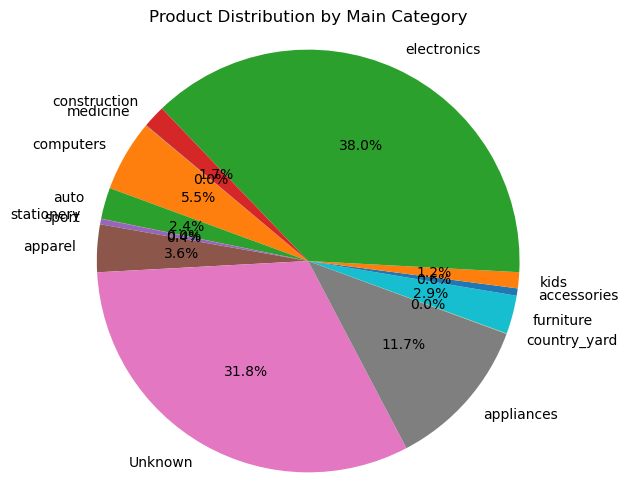

In [38]:
category_main_ratio_pd = category_main_ratio.toPandas()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(category_main_ratio_pd['product_ratio'], labels=category_main_ratio_pd['category_main'], autopct='%1.1f%%', startangle=140)
plt.title("Product Distribution by Main Category")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [44]:
category_conversion = df_no_nulls.groupBy("category_main").agg(
    count(when(col("event_type") == "view", True)).alias("view_count"),
    count(when(col("event_type") == "purchase", True)).alias("purchase_count")
)

# calculate conversion ratio
category_conversion = category_conversion.withColumn(
    "conversion_rate", col("purchase_count") / col("view_count")
)

category_conversion.show()

+-------------+----------+--------------+--------------------+
|category_main|view_count|purchase_count|     conversion_rate|
+-------------+----------+--------------+--------------------+
|     medicine|     13974|           310|  0.0221840561041935|
|    computers|   2268928|         27855|0.012276722751889879|
|         auto|    993428|         10620| 0.01069025636482966|
|   stationery|      7380|           134|0.018157181571815718|
|        sport|    174324|          1236|0.007090245749294...|
|      apparel|   1534896|          8002| 0.00521338253536396|
|      Unknown|  13236458|        173425| 0.01310207005529727|
|   appliances|   4799936|         74996|0.015624374991666556|
| country_yard|     13956|            72|0.005159071367153913|
|    furniture|   1236452|          8301|0.006713564295257721|
|  accessories|    236102|          1587|0.006721671142133485|
|         kids|    512485|          5482| 0.01069689844580817|
|  electronics|  15038390|        423028|0.028129872945

In [48]:
category_cart_conversion = df_no_nulls.groupBy("category_main").agg(
    count(when(col("event_type") == "cart", True)).alias("cart_count"),
    count(when(col("event_type") == "purchase", True)).alias("purchase_count")
)

category_cart_conversion = category_cart_conversion.withColumn(
    "cart_to_purchase_rate", col("purchase_count") / col("cart_count")
)

category_cart_conversion.show()


+-------------+----------+--------------+---------------------+
|category_main|cart_count|purchase_count|cart_to_purchase_rate|
+-------------+----------+--------------+---------------------+
|     medicine|       522|           310|   0.5938697318007663|
|    computers|     27434|         27855|   1.0153459211197784|
|         auto|      9067|         10620|   1.1712804676298665|
|   stationery|       106|           134|   1.2641509433962264|
|        sport|      1056|          1236|   1.1704545454545454|
|      apparel|        26|          8002|    307.7692307692308|
|      Unknown|    105726|        173425|   1.6403249910145092|
|   appliances|     92362|         74996|   0.8119789523830147|
| country_yard|        61|            72|    1.180327868852459|
|    furniture|      2407|          8301|   3.4486913169921065|
|  accessories|       549|          1587|    2.890710382513661|
|         kids|      2652|          5482|   2.0671191553544497|
|  electronics|    674205|        423028